Using device: cuda
Unique labels before any processing: ['human' 'ai']
Label distribution before processing:
 label
human    2000
ai       2000
Name: count, dtype: int64
Number of NaNs in labels: 0

Unique labels after mapping: [0 1]
Label distribution after mapping:
 label
0    2000
1    2000
Name: count, dtype: int64
Number of NaNs in labels after mapping: 0


Predicting:   0%|          | 0/32 [00:00<?, ?it/s]c:\Users\Jim\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
Predicting: 100%|██████████| 32/32 [00:02<00:00, 12.71it/s]


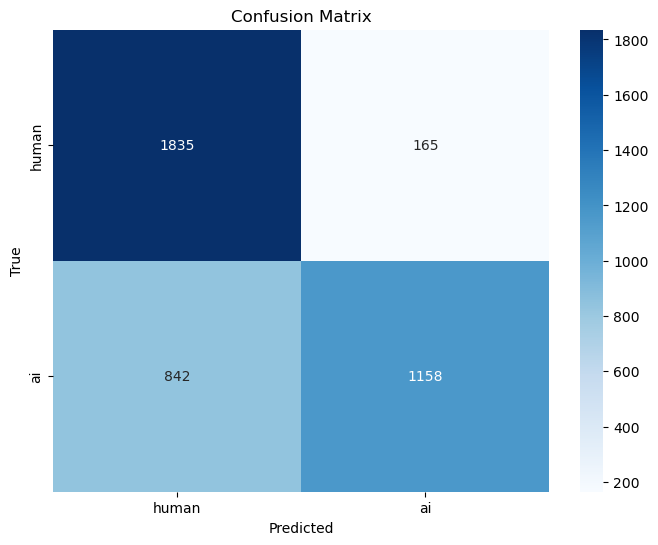


Classification Report:
              precision    recall  f1-score   support

       human       0.69      0.92      0.78      2000
          ai       0.88      0.58      0.70      2000

    accuracy                           0.75      4000
   macro avg       0.78      0.75      0.74      4000
weighted avg       0.78      0.75      0.74      4000



In [26]:
import os
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from tqdm import tqdm
import pandas as pd

# Ensure device is set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
batch_size = 128
max_length = 128
tokenizerPath = "tokenizer_path"
modelPath = "final_dataset_best_bengali_transformer.pt"

# Load data
df = pd.read_csv("../../Unseen Data/Unseen_dataset.csv")

# Debug: Inspect the label column
print("Unique labels before any processing:", df['label'].unique())
print("Label distribution before processing:\n", df['label'].value_counts(dropna=False))
print("Number of NaNs in labels:", df['label'].isnull().sum())

# Clean the data
# Convert labels to lowercase to handle case sensitivity
df['label'] = df['label'].str.lower().str.strip()
# Filter for valid labels
df = df[df['label'].isin(['human', 'ai'])]
# Remove NaNs in 'label' or 'text'
df = df.dropna(subset=['label', 'text'])

# Apply label mapping
label_map = {"human": 0, "ai": 1}
df["label"] = df["label"].map(label_map)

# Debug: Verify labels after mapping
print("\nUnique labels after mapping:", df['label'].unique())
print("Label distribution after mapping:\n", df['label'].value_counts(dropna=False))
print("Number of NaNs in labels after mapping:", df['label'].isnull().sum())

# Check for non-numeric labels or NaNs
if df['label'].isnull().any() or not all(isinstance(x, (int, np.integer)) for x in df['label']):
    problematic_rows = df[~df['label'].isin([0, 1])]
    print("Problematic rows with non-numeric labels or NaNs:\n", problematic_rows)
    # Save problematic rows for inspection
    problematic_rows.to_csv("problematic_rows.csv", index=False)
    raise ValueError("Labels contain non-numeric values or NaNs after mapping. Check problematic_rows.csv for details.")

# Prepare texts and labels
texts = df['text'].tolist()
labels = df['label'].tolist()

# Verify tokenizer
if not os.path.exists(tokenizerPath):
    raise FileNotFoundError(f"Tokenizer path {tokenizerPath} does not exist. Please train or provide a valid tokenizer.")
tokenizer = ByteLevelBPETokenizer(f"{tokenizerPath}/vocab.json", f"{tokenizerPath}/merges.txt")

# Define encode_batch function
def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids, attention_masks = [], []
    for e in encodings:
        ids = e.ids[:max_length] + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else e.ids[:max_length]
        mask = [1] * min(len(e.ids), max_length) + [0] * (max_length - len(e.ids))
        input_ids.append(ids)
        attention_masks.append(mask)
    return torch.tensor(input_ids), torch.tensor(attention_masks)

# Define dataset
class BengaliTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attention_mask = encode_batch(texts)
        self.labels = torch.tensor(labels, dtype=torch.long)  # Explicitly set dtype to long

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

# Define model
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=128, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        x = self.embedding(input_ids) + self.position_embedding(positions)
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = self.dropout(x[:, 0])  # Take CLS token representation
        return self.classifier(x)

# Create dataset and dataloader
dataset = BengaliTextDataset(texts, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Initialize and load model
vocab_size = tokenizer.get_vocab_size()
model = CustomTransformer(vocab_size=vocab_size, max_len=max_length, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2)
model.load_state_dict(torch.load(modelPath, map_location=device))
model.to(device)
model.eval()

# Make predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predictions and labels to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['human', 'ai'], yticklabels=['human', 'ai'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix_unseen.png")
plt.show()

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['human', 'ai']))

Using device: cuda
Unique labels before any processing: ['human' 'ai']
Label distribution before processing:
 label
human    1500
ai       1500
Name: count, dtype: int64
Number of NaNs in labels: 0

Unique labels after mapping: [0 1]
Label distribution after mapping:
 label
0    1500
1    1500
Name: count, dtype: int64
Number of NaNs in labels after mapping: 0


Predicting: 100%|██████████| 24/24 [00:01<00:00, 13.89it/s]


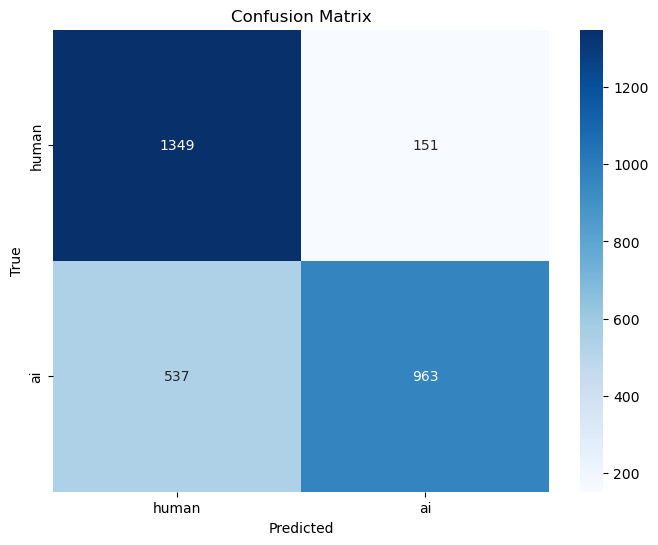


Classification Report:
              precision    recall  f1-score   support

       human       0.72      0.90      0.80      1500
          ai       0.86      0.64      0.74      1500

    accuracy                           0.77      3000
   macro avg       0.79      0.77      0.77      3000
weighted avg       0.79      0.77      0.77      3000



In [27]:
import os
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from tqdm import tqdm
import pandas as pd

# Ensure device is set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
batch_size = 128
max_length = 128
tokenizerPath = "tokenizer_path"
modelPath = "final_dataset_best_bengali_transformer.pt"

# Load data
df = pd.read_csv("../../Unseen Data/Paraphrased_dataset.csv")

# Debug: Inspect the label column
print("Unique labels before any processing:", df['label'].unique())
print("Label distribution before processing:\n", df['label'].value_counts(dropna=False))
print("Number of NaNs in labels:", df['label'].isnull().sum())

# Clean the data
# Convert labels to lowercase to handle case sensitivity
df['label'] = df['label'].str.lower().str.strip()
# Filter for valid labels
df = df[df['label'].isin(['human', 'ai'])]
# Remove NaNs in 'label' or 'text'
df = df.dropna(subset=['label', 'text'])

# Apply label mapping
label_map = {"human": 0, "ai": 1}
df["label"] = df["label"].map(label_map)

# Debug: Verify labels after mapping
print("\nUnique labels after mapping:", df['label'].unique())
print("Label distribution after mapping:\n", df['label'].value_counts(dropna=False))
print("Number of NaNs in labels after mapping:", df['label'].isnull().sum())

# Check for non-numeric labels or NaNs
if df['label'].isnull().any() or not all(isinstance(x, (int, np.integer)) for x in df['label']):
    problematic_rows = df[~df['label'].isin([0, 1])]
    print("Problematic rows with non-numeric labels or NaNs:\n", problematic_rows)
    # Save problematic rows for inspection
    problematic_rows.to_csv("problematic_rows.csv", index=False)
    raise ValueError("Labels contain non-numeric values or NaNs after mapping. Check problematic_rows.csv for details.")

# Prepare texts and labels
texts = df['text'].tolist()
labels = df['label'].tolist()

# Verify tokenizer
if not os.path.exists(tokenizerPath):
    raise FileNotFoundError(f"Tokenizer path {tokenizerPath} does not exist. Please train or provide a valid tokenizer.")
tokenizer = ByteLevelBPETokenizer(f"{tokenizerPath}/vocab.json", f"{tokenizerPath}/merges.txt")

# Define encode_batch function
def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids, attention_masks = [], []
    for e in encodings:
        ids = e.ids[:max_length] + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else e.ids[:max_length]
        mask = [1] * min(len(e.ids), max_length) + [0] * (max_length - len(e.ids))
        input_ids.append(ids)
        attention_masks.append(mask)
    return torch.tensor(input_ids), torch.tensor(attention_masks)

# Define dataset
class BengaliTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attention_mask = encode_batch(texts)
        self.labels = torch.tensor(labels, dtype=torch.long)  # Explicitly set dtype to long

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

# Define model
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=128, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        x = self.embedding(input_ids) + self.position_embedding(positions)
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = self.dropout(x[:, 0])  # Take CLS token representation
        return self.classifier(x)

# Create dataset and dataloader
dataset = BengaliTextDataset(texts, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Initialize and load model
vocab_size = tokenizer.get_vocab_size()
model = CustomTransformer(vocab_size=vocab_size, max_len=max_length, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2)
model.load_state_dict(torch.load(modelPath, map_location=device))
model.to(device)
model.eval()

# Make predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predictions and labels to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['human', 'ai'], yticklabels=['human', 'ai'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix_Paraphrased_dataset.png")
plt.show()

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['human', 'ai']))